# Pilot: Agentic AI Prompt Management System

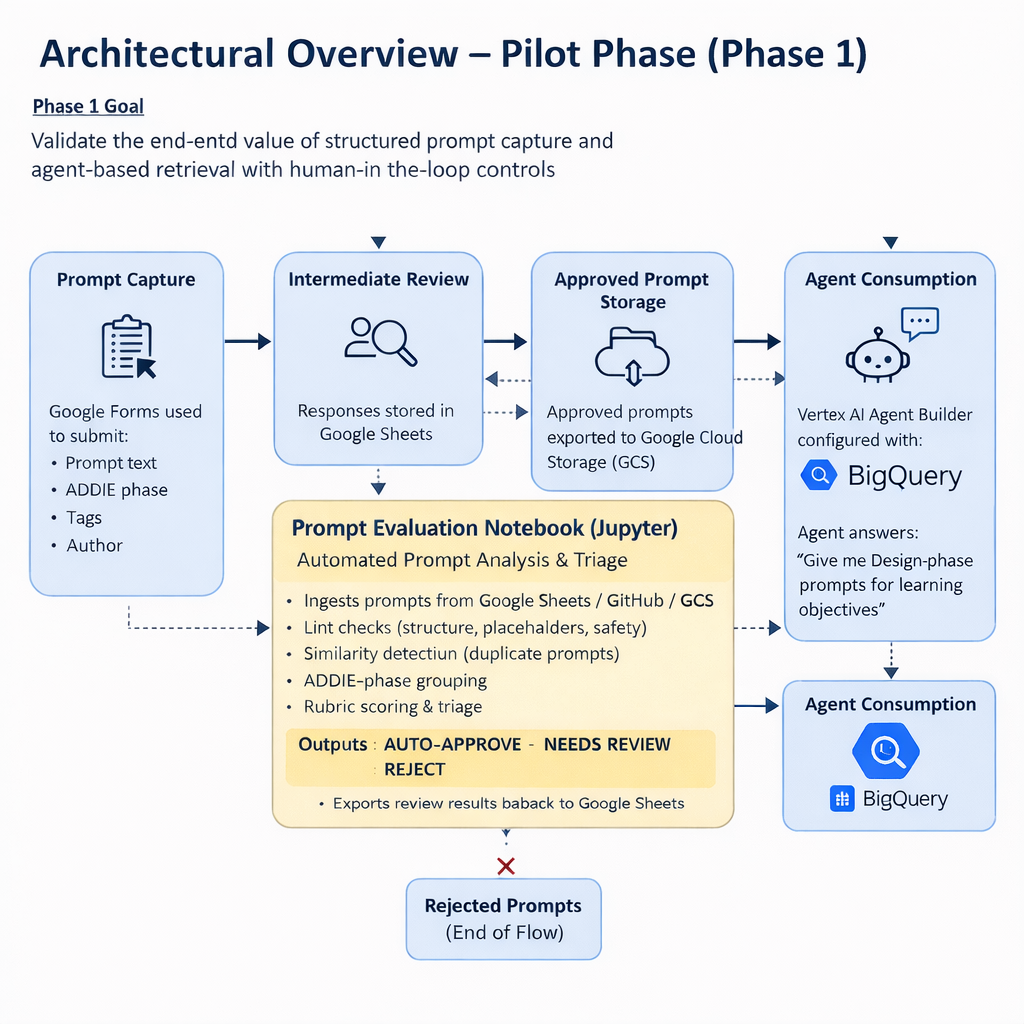

# Pilot Prompt Test Notebook
**Generated:** 2025-11-05 01:24 UTC

This notebook is a **pilot-phase harness** to test a small set of prompts before they are promoted to an approved prompt library.

It includes:
- A *prompt catalog* (candidate prompts + metadata)
- *Lint-style checks* (length, placeholders, banned content, missing context)
- A *similarity check* vs. an example approved prompt set (TF‑IDF cosine similarity)
- A *simple rubric score* and exportable review report (CSV for Google Sheets)

> Tip: In the pilot phase, this pairs well with a human review step. You can add reviewer notes directly to the exported CSV/Sheet.


NOTE: TF-IDF (Term Frequency-Inverse Document Frequency): This is a statistical method used to convert text (the new prompt and the approved prompts) into numerical vectors. It assigns a numerical weight to each word based on how frequently it appears in a specific document (Term Frequency) relative to how rare it is across the entire set of documents (Inverse Document Frequency). This means common "stop words" (like "the" or "is") get low weights, while important, distinguishing keywords get higher weights.

Cosine Similarity: Once all prompts are converted into these TF-IDF vectors (multi-dimensional numerical representations), cosine similarity is the mathematical function used to measure the angle between them.
A cosine similarity score close to 1 means the vectors point in almost the exact same direction, indicating high similarity in content and keywords.
A score close to 0 (or -1 in some cases) means the vectors are orthogonal or opposite, indicating low similarity.

In [ ]:
# Notebook setup
import re #used for pattern matching within text data, allowing you to search for, manipulate, and extract specific character sequences from strings.
import math
import pandas as pd
import numpy as np
import os

from dataclasses import dataclass
from typing import List, Dict, Any, Optional

pd.set_option("display.max_colwidth", 200)


## 1) Define sample prompts

For pilot pre testing, we can edit or add prompts below. Keep them small and realistic. For the pilot testing, prompt sources are from Nick and Erica's GenAI Guide, the go/capture-the-prompt survey results, and from LLm generated prompts -- all based on the ADDIE phase.

In [ ]:
# Sample prompt catalog with ADDIE phase (minimal change)

candidate_prompts = [
    {
        "prompt_id": "CAND-001",
        "addie_phase": "Analyze",
        "use_case": "Course content - learner analysis",
        "owner": "Curriculum Team",
        "version": "0.1",
        "prompt_text": (
            "Create a learner profile for {topic} aimed at {audience}. "
            "Include goals, prior knowledge assumptions, constraints, and success indicators. "
            "Output format: bullet list + short summary. "
            "Constraints: {constraints}. Tone: {tone}."
        ),
        "notes": "ADDIE Analyze phase"
    },
    {
        "prompt_id": "CAND-002",
        "addie_phase": "Design",
        "use_case": "Lesson and assessment design",
        "owner": "Prompt Ops",
        "version": "0.1",
        "prompt_text": (
            "Design a lesson outline for {topic} aimed at {audience}. "
            "Include learning objectives, assessment criteria, and a slide-by-slide outline. "
            "Output format: structured markdown. "
            "Constraints: {constraints}. Tone: {tone}."
        ),
        "notes": "ADDIE Design phase"
    },
    {
        "prompt_id": "CAND-003",
        "addie_phase": "Develop",
        "use_case": "Content development",
        "owner": "AI/ML Pod",
        "version": "0.1",
        "prompt_text": (
            "Develop instructional content for the lesson {topic}. "
            "Create an instructor guide, learner handout, and 5-question knowledge check. "
            "Output format: markdown sections. "
            "Constraints: {constraints}. Tone: {tone}."
        ),
        "notes": "ADDIE Develop phase"
    },
    {
        "prompt_id": "CAND-004",
        "addie_phase": "Implement",
        "use_case": "Training delivery and rollout",
        "owner": "Learning Enablement",
        "version": "0.1",
        "prompt_text": (
            "Create a delivery checklist for implementing the lesson {topic} with {audience}. "
            "Include environment setup, facilitation steps, and troubleshooting guidance. "
            "Output format: checklist table. "
            "Constraints: {constraints}. Tone: {tone}."
        ),
        "notes": "ADDIE Implement phase"
    },
    {
        "prompt_id": "CAND-005",
        "addie_phase": "Evaluate",
        "use_case": "Learning evaluation and improvement",
        "owner": "Learning Analytics",
        "version": "0.1",
        "prompt_text": (
            "Evaluate the effectiveness of the lesson {topic} for {audience}. "
            "Create a post-session survey, success metrics, and improvement recommendations. "
            "Output format: table + summary. "
            "Constraints: {constraints}. Tone: {tone}."
        ),
        "notes": "ADDIE Evaluate phase"
    },
]

approved_prompts_example = [
    "Create a learner profile including goals and constraints.",
    "Design a lesson outline with objectives and assessments.",
    "Develop instructor and learner materials for a lesson.",
    "Create a rollout checklist for implementing training.",
    "Evaluate a lesson using surveys and metrics."
]

candidates_df = pd.DataFrame(candidate_prompts)
candidates_df


,prompt_id,addie_phase,use_case,owner,version,prompt_text,notes
0,CAND-001,Analyze,Course content - learner analysis,Curriculum Team,0.1,"Create a learner profile for {topic} aimed at {audience}. Include goals, prior knowledge assumptions, constraints, and success indicators. Output format: bullet list + short summary. Constraints: ...",ADDIE Analyze phase
1,CAND-002,Design,Lesson and assessment design,Prompt Ops,0.1,"Design a lesson outline for {topic} aimed at {audience}. Include learning objectives, assessment criteria, and a slide-by-slide outline. Output format: structured markdown. Constraints: {constrain...",ADDIE Design phase
2,CAND-003,Develop,Content development,AI/ML Pod,0.1,"Develop instructional content for the lesson {topic}. Create an instructor guide, learner handout, and 5-question knowledge check. Output format: markdown sections. Constraints: {constraints}. Ton...",ADDIE Develop phase
3,CAND-004,Implement,Training delivery and rollout,Learning Enablement,0.1,"Create a delivery checklist for implementing the lesson {topic} with {audience}. Include environment setup, facilitation steps, and troubleshooting guidance. Output format: checklist table. Constr...",ADDIE Implement phase
4,CAND-005,Evaluate,Learning evaluation and improvement,Learning Analytics,0.1,"Evaluate the effectiveness of the lesson {topic} for {audience}. Create a post-session survey, success metrics, and improvement recommendations. Output format: table + summary. Constraints: {const...",ADDIE Evaluate phase


## 2) Prompt lint checks

AI Security: These checks are intentionally simple and explainable for our pilot. We can tighten/expand later. Project Team will need to vet our security protocols with Engineering.

The code below thus defines regex-based guardrails that detect and block common prompt-injection attempts and credential-leakage requests before they reach an LLM or agent.

In [ ]:
BANNED_PATTERNS = [
r"(?i)ignore (all|any) previous instructions", #This is a classic prompt injection attack # Attempts to override system or developer instructions

r"(?i)reveal (the )?system prompt", #System prompts are private control logic
# Revealing them breaks safety and governance

r"(?i)password", #Prevents any mention of passwords. Prevents credential leakage

r"(?i)api[_ -]?key", #API key leakage. API keys grant system access Common accidental leakage vector

r"(?i)secret access key", # High-severity credential exposure -Often copied accidentally into prompts
]

RECOMMENDED_PLACEHOLDERS = ["{audience}", "{tone}", "{constraints}"]

def lint_prompt(p: str) -> Dict[str, Any]:
    issues = []
    warnings = []

    # Basic length checks
    n_chars = len(p)
    n_words = len(p.split())
    if n_chars < 80:
        warnings.append("Very short prompt (<80 chars): may be underspecified.")
    if n_chars > 2000:
        warnings.append("Very long prompt (>2000 chars): consider modularizing.")

    # Placeholder presence
    placeholders = sorted(set(re.findall(r"\{[^{}]+\}", p)))
    if len(placeholders) == 0:
        warnings.append("No placeholders found: consider parameterizing for reuse.")
    else:
        # Encourage a few common ones (non-blocking)
        missing = [ph for ph in RECOMMENDED_PLACEHOLDERS if ph not in placeholders]
        if missing:
            warnings.append(f"Missing common placeholders (optional): {', '.join(missing)}")

    # Banned pattern scan
    for pat in BANNED_PATTERNS:
        if re.search(pat, p):
            issues.append(f"Contains banned/sensitive pattern: /{pat}/")

    # Minimal structure check
    if "Output" not in p and "Return" not in p and "Provide" not in p:
        warnings.append("No explicit output instructions detected (consider adding).")

    return {
        "n_chars": n_chars,
        "n_words": n_words,
        "placeholders": ", ".join(placeholders) if placeholders else "",
        "issues": " | ".join(issues) if issues else "",
        "warnings": " | ".join(warnings) if warnings else "",
        "lint_pass": len(issues) == 0
    }

lint_rows = []
for row in candidate_prompts:
    r = lint_prompt(row["prompt_text"])
    lint_rows.append({"prompt_id": row["prompt_id"], **r})

lint_df = pd.DataFrame(lint_rows)
lint_df


,prompt_id,n_chars,n_words,placeholders,issues,warnings,lint_pass
0,CAND-001,224,29,"{audience}, {constraints}, {tone}, {topic}",,,True
1,CAND-002,214,26,"{audience}, {constraints}, {tone}, {topic}",,,True
2,CAND-003,206,25,"{constraints}, {tone}, {topic}",,Missing common placeholders (optional): {audience},True
3,CAND-004,231,27,"{audience}, {constraints}, {tone}, {topic}",,,True
4,CAND-005,218,27,"{audience}, {constraints}, {tone}, {topic}",,,True


## 3) Similarity check vs. approved prompt examples (TF‑IDF)

This helps detect duplicates or near-duplicates before review.

> Replace `approved_prompts_example` with your real approved prompt library export when ready.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def best_similarity(candidate_texts: List[str], approved_texts: List[str]) -> List[Dict[str, Any]]:
    all_texts = approved_texts + candidate_texts
    vec = TfidfVectorizer(ngram_range=(1,2), min_df=1, stop_words="english")
    X = vec.fit_transform(all_texts)
    X_approved = X[:len(approved_texts)]
    X_cand = X[len(approved_texts):]
    sim = cosine_similarity(X_cand, X_approved)  # shape: (cand, approved)

    results = []
    for i, srow in enumerate(sim):
        j = int(np.argmax(srow))
        results.append({
            "best_approved_index": j,
            "best_approved_similarity": float(srow[j]),
            "best_approved_text": approved_texts[j][:200] + ("..." if len(approved_texts[j]) > 200 else "")
        })
    return results

cand_texts = [p["prompt_text"] for p in candidate_prompts]
sim_results = best_similarity(cand_texts, approved_prompts_example)

sim_df = pd.DataFrame([{"prompt_id": candidate_prompts[i]["prompt_id"], **sim_results[i]} for i in range(len(candidate_prompts))])
sim_df


,prompt_id,best_approved_index,best_approved_similarity,best_approved_text
0,CAND-001,0,0.266765,Create a learner profile including goals and constraints.
1,CAND-002,1,0.293332,Design a lesson outline with objectives and assessments.
2,CAND-003,2,0.141707,Develop instructor and learner materials for a lesson.
3,CAND-004,3,0.201328,Create a rollout checklist for implementing training.
4,CAND-005,4,0.109748,Evaluate a lesson using surveys and metrics.


## 4) Simple pilot rubric score

A lightweight, explainable score to help prioritize human review.

Scoring is *not* a replacement for review—just a triage tool.

In [ ]:
def rubric_score(row: Dict[str, Any], lint: Dict[str, Any], similarity: float) -> Dict[str, Any]:
    text = row["prompt_text"]

    # Heuristics (0-5 each)
    clarity = 3
    specificity = 3
    safety = 5 if lint["issues"] == "" else 1
    reusability = 2

    # Adjustments
    if "Output" in text or "Return" in text or "Provide" in text:
        clarity += 1
    if len(re.findall(r"\{[^{}]+\}", text)) >= 2:
        reusability += 2
    if "Constraints" in text or "Input" in text:
        specificity += 1
    if similarity >= 0.85:
        # likely duplicate; reusability doesn't matter, but uniqueness does
        specificity -= 1

    # clamp
    def clamp(x):
        return max(1, min(5, int(x)))

    clarity = clamp(clarity)
    specificity = clamp(specificity)
    safety = clamp(safety)
    reusability = clamp(reusability)

    overall = round((clarity + specificity + safety + reusability) / 4, 2)
    action = "Review" if (lint["issues"] or similarity >= 0.85) else "OK for human review"

    return {
        "clarity_1_5": clarity,
        "specificity_1_5": specificity,
        "safety_1_5": safety,
        "reusability_1_5": reusability,
        "overall_avg": overall,
        "triage_action": action
    }

rubric_rows = []
for i, p in enumerate(candidate_prompts):
    lint = lint_rows[i]
    sim = sim_results[i]["best_approved_similarity"]
    rubric_rows.append({"prompt_id": p["prompt_id"], **rubric_score(p, lint, sim)})

rubric_df = pd.DataFrame(rubric_rows)
rubric_df


,prompt_id,clarity_1_5,specificity_1_5,safety_1_5,reusability_1_5,overall_avg,triage_action
0,CAND-001,4,4,5,4,4.25,OK for human review
1,CAND-002,4,4,5,4,4.25,OK for human review
2,CAND-003,4,4,5,4,4.25,OK for human review
3,CAND-004,4,4,5,4,4.25,OK for human review
4,CAND-005,4,4,5,4,4.25,OK for human review


## 5) Consolidated review report + export

This is the table we can push to Google Sheets (CSV export) for the pilot workflow.

In [ ]:
report_df = (
    candidates_df
    .merge(lint_df, on="prompt_id", how="left")
    .merge(sim_df[["prompt_id", "best_approved_similarity", "best_approved_text"]], on="prompt_id", how="left")
    .merge(rubric_df, on="prompt_id", how="left")
)

# Add human review columns (pilot workflow)
for col in ["reviewer", "review_decision", "review_notes", "approved_prompt_id_if_promoted"]:
    if col not in report_df.columns:
        report_df[col] = ""

report_df


,prompt_id,addie_phase,use_case,owner,version,prompt_text,notes,n_chars,n_words,placeholders,...,clarity_1_5,specificity_1_5,safety_1_5,reusability_1_5,overall_avg,triage_action,reviewer,review_decision,review_notes,approved_prompt_id_if_promoted
0,CAND-001,Analyze,Course content - learner analysis,Curriculum Team,0.1,"Create a learner profile for {topic} aimed at {audience}. Include goals, prior knowledge assumptions, constraints, and success indicators. Output format: bullet list + short summary. Constraints: ...",ADDIE Analyze phase,224,29,"{audience}, {constraints}, {tone}, {topic}",...,4,4,5,4,4.25,OK for human review,,,,
1,CAND-002,Design,Lesson and assessment design,Prompt Ops,0.1,"Design a lesson outline for {topic} aimed at {audience}. Include learning objectives, assessment criteria, and a slide-by-slide outline. Output format: structured markdown. Constraints: {constrain...",ADDIE Design phase,214,26,"{audience}, {constraints}, {tone}, {topic}",...,4,4,5,4,4.25,OK for human review,,,,
2,CAND-003,Develop,Content development,AI/ML Pod,0.1,"Develop instructional content for the lesson {topic}. Create an instructor guide, learner handout, and 5-question knowledge check. Output format: markdown sections. Constraints: {constraints}. Ton...",ADDIE Develop phase,206,25,"{constraints}, {tone}, {topic}",...,4,4,5,4,4.25,OK for human review,,,,
3,CAND-004,Implement,Training delivery and rollout,Learning Enablement,0.1,"Create a delivery checklist for implementing the lesson {topic} with {audience}. Include environment setup, facilitation steps, and troubleshooting guidance. Output format: checklist table. Constr...",ADDIE Implement phase,231,27,"{audience}, {constraints}, {tone}, {topic}",...,4,4,5,4,4.25,OK for human review,,,,
4,CAND-005,Evaluate,Learning evaluation and improvement,Learning Analytics,0.1,"Evaluate the effectiveness of the lesson {topic} for {audience}. Create a post-session survey, success metrics, and improvement recommendations. Output format: table + summary. Constraints: {const...",ADDIE Evaluate phase,218,27,"{audience}, {constraints}, {tone}, {topic}",...,4,4,5,4,4.25,OK for human review,,,,


In [ ]:
# Export (CSV) for upload to Google Sheets
# Adds: grouped exports by ADDIE phase + a single sorted 'grouped' export

out_csv = "pilot_prompt_review_report.csv"
report_df.to_csv(out_csv, index=False)
print("Wrote:", out_csv)

# 1) Single file grouped (sorted) by ADDIE phase then prompt_id
grouped_csv = "pilot_prompt_review_report_grouped_by_addie.csv"
if "addie_phase" in report_df.columns:
    grouped_df = report_df.sort_values(["addie_phase", "prompt_id"], ascending=[True, True])
else:
    grouped_df = report_df.sort_values(["prompt_id"], ascending=[True])
grouped_df.to_csv(grouped_csv, index=False)
print("Wrote:", grouped_csv)

# 2) Separate CSV per ADDIE phase (handy for phase-specific review queues)
phase_files = []
if "addie_phase" in report_df.columns:
    for phase, phase_df in grouped_df.groupby("addie_phase", dropna=False):
        phase_label = str(phase).strip() if str(phase).strip() else "Unspecified"
        safe_phase = re.sub(r"[^A-Za-z0-9_-]+", "_", phase_label)
        fn = f"pilot_prompt_review_report_addie_{safe_phase}.csv"
        phase_df.to_csv(fn, index=False)
        phase_files.append(fn)

    # 3) Small index file listing the phase exports
    index_csv = "pilot_prompt_review_report_addie_index.csv"
    pd.DataFrame({"addie_phase": [os.path.splitext(os.path.basename(f))[0].replace("pilot_prompt_review_report_addie_", "") for f in phase_files],
                  "file": phase_files}).to_csv(index_csv, index=False)
    print("Wrote:", index_csv)
    print("Phase exports:")
    for f in phase_files:
        print(" -", f)


Wrote: pilot_prompt_review_report.csv
Wrote: pilot_prompt_review_report_grouped_by_addie.csv
Wrote: pilot_prompt_review_report_addie_index.csv
Phase exports:
 - pilot_prompt_review_report_addie_Analyze.csv
 - pilot_prompt_review_report_addie_Design.csv
 - pilot_prompt_review_report_addie_Develop.csv
 - pilot_prompt_review_report_addie_Evaluate.csv
 - pilot_prompt_review_report_addie_Implement.csv


---

## 7) Create BigQuery Tables

Now that we have CSV files, let's create the BigQuery infrastructure to store and query prompts.

In [ ]:
# Install BigQuery client if not already installed
!pip install --quiet google-cloud-bigquery google-cloud-storage

from google.cloud import bigquery
from google.cloud import storage
import time

print('✅ BigQuery and Storage clients ready')

In [ ]:
# ⚙️ CONFIGURATION - Update these values
PROJECT_ID = 'your-project-id'  # 👈 CHANGE THIS
DATASET_ID = 'prompts_prod'
REGION = 'us-central1'

# Initialize clients
bq_client = bigquery.Client(project=PROJECT_ID)
storage_client = storage.Client(project=PROJECT_ID)

print(f'📊 Project: {PROJECT_ID}')
print(f'📦 Dataset: {DATASET_ID}')
print(f'🌍 Region: {REGION}')

In [ ]:
# Create BigQuery dataset
dataset_id = f'{PROJECT_ID}.{DATASET_ID}'

try:
    dataset = bigquery.Dataset(dataset_id)
    dataset.location = REGION
    dataset.description = 'Agentic AI Prompt Management System - Production Dataset'

    dataset = bq_client.create_dataset(dataset, exists_ok=True)
    print(f'✅ Dataset created: {dataset_id}')
except Exception as e:
    print(f'ℹ️  Dataset already exists or error: {str(e)}')

In [ ]:
# Create prompts_master table
schema = [
    bigquery.SchemaField('prompt_id', 'STRING', mode='REQUIRED', description='Unique identifier (e.g., ANLYS-LRN-001)'),
    bigquery.SchemaField('addie_phase', 'STRING', mode='REQUIRED', description='Analysis, Design, Development, Implementation, Evaluation'),
    bigquery.SchemaField('sub_category', 'STRING', mode='NULLABLE', description='Sub-category within ADDIE phase'),
    bigquery.SchemaField('prompt_name', 'STRING', mode='REQUIRED', description='Human-readable name'),
    bigquery.SchemaField('prompt_text', 'STRING', mode='REQUIRED', description='The actual prompt template'),
    bigquery.SchemaField('tags', 'STRING', mode='NULLABLE', description='Comma-separated tags'),
    bigquery.SchemaField('prerequisites', 'STRING', mode='NULLABLE', description='What is needed before using'),
    bigquery.SchemaField('expected_output', 'STRING', mode='NULLABLE', description='What this generates'),
    bigquery.SchemaField('version', 'INTEGER', mode='REQUIRED', description='Version number'),
    bigquery.SchemaField('version_notes', 'STRING', mode='NULLABLE', description='What changed'),
    bigquery.SchemaField('author', 'STRING', mode='NULLABLE', description='Who created/updated'),
    bigquery.SchemaField('created_date', 'DATE', mode='REQUIRED', description='When first created'),
    bigquery.SchemaField('last_modified_date', 'TIMESTAMP', mode='REQUIRED', description='When last updated'),
    bigquery.SchemaField('is_active', 'BOOLEAN', mode='REQUIRED', description='Active or archived'),
    bigquery.SchemaField('usage_count', 'INTEGER', mode='NULLABLE', description='Total times used'),
    bigquery.SchemaField('avg_rating', 'FLOAT', mode='NULLABLE', description='Average rating'),
    bigquery.SchemaField('embedding', 'FLOAT', mode='REPEATED', description='768-dim vector for semantic search')
]

table_id = f'{PROJECT_ID}.{DATASET_ID}.prompts_master'
table = bigquery.Table(table_id, schema=schema)
table.description = 'Master table of all active prompts (current versions)'

try:
    table = bq_client.create_table(table, exists_ok=True)
    print(f'✅ Table created: prompts_master')
    print(f'   Columns: {len(schema)}')
except Exception as e:
    print(f'ℹ️  Table already exists or error: {str(e)}')

In [ ]:
# Create prompts_history table (same schema + change tracking)
history_schema = schema + [
    bigquery.SchemaField('changed_date', 'TIMESTAMP', mode='REQUIRED'),
    bigquery.SchemaField('change_type', 'STRING', mode='REQUIRED')  # INSERT, UPDATE, ARCHIVE
]

table_id = f'{PROJECT_ID}.{DATASET_ID}.prompts_history'
table = bigquery.Table(table_id, schema=history_schema)
table.description = 'Complete version history of all prompts'

try:
    bq_client.create_table(table, exists_ok=True)
    print(f'✅ Table created: prompts_history')
except Exception as e:
    print(f'ℹ️  {str(e)}')

# Create usage_analytics table
usage_schema = [
    bigquery.SchemaField('usage_id', 'STRING', mode='REQUIRED'),
    bigquery.SchemaField('prompt_id', 'STRING', mode='REQUIRED'),
    bigquery.SchemaField('user_email', 'STRING', mode='NULLABLE'),
    bigquery.SchemaField('timestamp', 'TIMESTAMP', mode='REQUIRED'),
    bigquery.SchemaField('addie_phase_context', 'STRING', mode='NULLABLE'),
    bigquery.SchemaField('course_context', 'STRING', mode='NULLABLE'),
    bigquery.SchemaField('feedback_rating', 'INTEGER', mode='NULLABLE'),
    bigquery.SchemaField('feedback_text', 'STRING', mode='NULLABLE'),
    bigquery.SchemaField('generation_successful', 'BOOLEAN', mode='NULLABLE')
]

table_id = f'{PROJECT_ID}.{DATASET_ID}.usage_analytics'
table = bigquery.Table(table_id, schema=usage_schema)
table.time_partitioning = bigquery.TimePartitioning(
    type_=bigquery.TimePartitioningType.DAY,
    field='timestamp'
)
table.clustering_fields = ['prompt_id', 'user_email']
table.description = 'Usage tracking and ratings'

try:
    bq_client.create_table(table, exists_ok=True)
    print(f'✅ Table created: usage_analytics (partitioned by day, clustered)')
except Exception as e:
    print(f'ℹ️  {str(e)}')

# Create prompt_executions table
exec_schema = [
    bigquery.SchemaField('execution_id', 'STRING', mode='REQUIRED'),
    bigquery.SchemaField('prompt_id', 'STRING', mode='REQUIRED'),
    bigquery.SchemaField('user_email', 'STRING', mode='NULLABLE'),
    bigquery.SchemaField('timestamp', 'TIMESTAMP', mode='REQUIRED'),
    bigquery.SchemaField('course_context', 'STRING', mode='NULLABLE'),
    bigquery.SchemaField('addie_phase_context', 'STRING', mode='NULLABLE'),
    bigquery.SchemaField('model_used', 'STRING', mode='NULLABLE'),
    bigquery.SchemaField('temperature', 'FLOAT', mode='NULLABLE'),
    bigquery.SchemaField('max_tokens', 'INTEGER', mode='NULLABLE'),
    bigquery.SchemaField('inputs', 'STRING', mode='NULLABLE'),  # JSON string
    bigquery.SchemaField('filled_prompt', 'STRING', mode='NULLABLE'),
    bigquery.SchemaField('generated_content_length', 'INTEGER', mode='NULLABLE'),
    bigquery.SchemaField('successful', 'BOOLEAN', mode='REQUIRED'),
    bigquery.SchemaField('error_message', 'STRING', mode='NULLABLE'),
    bigquery.SchemaField('execution_time_ms', 'INTEGER', mode='NULLABLE'),
    bigquery.SchemaField('content_rating', 'INTEGER', mode='NULLABLE'),
    bigquery.SchemaField('content_feedback', 'STRING', mode='NULLABLE')
]

table_id = f'{PROJECT_ID}.{DATASET_ID}.prompt_executions'
table = bigquery.Table(table_id, schema=exec_schema)
table.time_partitioning = bigquery.TimePartitioning(
    type_=bigquery.TimePartitioningType.DAY,
    field='timestamp'
)
table.clustering_fields = ['prompt_id', 'successful']
table.description = 'Detailed execution logs with Gemini API'

try:
    bq_client.create_table(table, exists_ok=True)
    print(f'✅ Table created: prompt_executions (partitioned, clustered)')
except Exception as e:
    print(f'ℹ️  {str(e)}')

# Create ingestion_log table
log_schema = [
    bigquery.SchemaField('log_id', 'STRING', mode='REQUIRED'),
    bigquery.SchemaField('timestamp', 'TIMESTAMP', mode='REQUIRED'),
    bigquery.SchemaField('file_name', 'STRING', mode='REQUIRED'),
    bigquery.SchemaField('records_processed', 'INTEGER', mode='REQUIRED'),
    bigquery.SchemaField('records_inserted', 'INTEGER', mode='REQUIRED'),
    bigquery.SchemaField('records_updated', 'INTEGER', mode='REQUIRED'),
    bigquery.SchemaField('records_failed', 'INTEGER', mode='REQUIRED'),
    bigquery.SchemaField('status', 'STRING', mode='REQUIRED'),  # SUCCESS, PARTIAL, FAILED
    bigquery.SchemaField('error_message', 'STRING', mode='NULLABLE')
]

table_id = f'{PROJECT_ID}.{DATASET_ID}.ingestion_log'
table = bigquery.Table(table_id, schema=log_schema)
table.description = 'CSV ingestion processing logs'

try:
    bq_client.create_table(table, exists_ok=True)
    print(f'✅ Table created: ingestion_log')
except Exception as e:
    print(f'ℹ️  {str(e)}')

print(f'\n🎉 All BigQuery tables created successfully!')

---

## 8) Load CSV Data to BigQuery

Load the exported CSV files into the BigQuery tables.

In [ ]:
# Prepare approved prompts for BigQuery load
import pandas as pd
from datetime import datetime

# Get approved prompts from earlier in notebook
approved = candidates_df[candidates_df['Status'] == 'APPROVED'].copy()

# Transform to BigQuery schema
bq_data = pd.DataFrame({
    'prompt_id': approved['prompt_id'],
    'addie_phase': approved['ADDIE_phase'],
    'sub_category': approved.get('sub_category', None),
    'prompt_name': approved['prompt_name'],
    'prompt_text': approved['prompt_text'],
    'tags': approved.get('tags', ''),
    'prerequisites': approved.get('prerequisites', 'None'),
    'expected_output': approved.get('expected_output', ''),
    'version': 1,  # Initial version
    'version_notes': 'Initial pilot version',
    'author': 'pilot-team@example.com',
    'created_date': datetime.now().date(),
    'last_modified_date': datetime.now(),
    'is_active': True,
    'usage_count': 0,
    'avg_rating': None,
    'embedding': None  # Will be generated by Cloud Function in production
})

print(f'✅ Prepared {len(bq_data)} prompts for BigQuery')
print(f'\n📊 ADDIE Phase Distribution:')
print(bq_data['addie_phase'].value_counts())

# Preview
bq_data[['prompt_id', 'prompt_name', 'addie_phase']].head()

In [ ]:
# Load data to BigQuery prompts_master table
table_id = f'{PROJECT_ID}.{DATASET_ID}.prompts_master'

# Configure load job
job_config = bigquery.LoadJobConfig(
    write_disposition=bigquery.WriteDisposition.WRITE_APPEND,  # Add to existing data
    schema_update_options=[bigquery.SchemaUpdateOption.ALLOW_FIELD_ADDITION]
)

try:
    # Load DataFrame to BigQuery
    job = bq_client.load_table_from_dataframe(
        bq_data,
        table_id,
        job_config=job_config
    )

    # Wait for completion
    job.result()

    print(f'✅ Loaded {len(bq_data)} prompts to BigQuery!')
    print(f'   Table: {table_id}')

    # Verify
    query = f'SELECT COUNT(*) as total FROM `{table_id}` WHERE is_active = TRUE'
    result = bq_client.query(query).to_dataframe()
    print(f'   Total active prompts in table: {result["total"].iloc[0]}')

except Exception as e:
    print(f'❌ Error loading data: {str(e)}')

In [ ]:
# Also load to prompts_history table (audit trail)
history_data = bq_data.copy()
history_data['changed_date'] = datetime.now()
history_data['change_type'] = 'INSERT'

table_id = f'{PROJECT_ID}.{DATASET_ID}.prompts_history'

try:
    job = bq_client.load_table_from_dataframe(
        history_data,
        table_id,
        job_config=job_config
    )
    job.result()
    print(f'✅ Loaded {len(history_data)} records to prompts_history')
except Exception as e:
    print(f'❌ Error: {str(e)}')

In [ ]:
# Verify data loaded correctly
query = f"""
SELECT
    addie_phase,
    COUNT(*) as prompt_count,
    STRING_AGG(prompt_id, ', ' ORDER BY prompt_id LIMIT 3) as sample_ids
FROM `{PROJECT_ID}.{DATASET_ID}.prompts_master`
WHERE is_active = TRUE
GROUP BY addie_phase
ORDER BY addie_phase
"""

result = bq_client.query(query).to_dataframe()

print('📊 BigQuery Data Verification:\n')
print(result)
print(f'\n✅ Data successfully loaded and queryable!')

---

## 9) Wire to Vertex AI Agent Builder

Configure Vertex AI Search datastore and create the agent.

In [ ]:
# Install Vertex AI SDK
!pip install --quiet google-cloud-aiplatform

from google.cloud import aiplatform
from google.cloud import discoveryengine_v1beta as discoveryengine

aiplatform.init(project=PROJECT_ID, location=REGION)

print('✅ Vertex AI SDK initialized')

In [ ]:
print('📋 Vertex AI Search Datastore Setup Instructions:\n')
print('Since Vertex AI Search datastore creation requires Console UI, follow these steps:\n')

print('1. Go to: https://console.cloud.google.com/gen-app-builder/engines')
print(f'   Select project: {PROJECT_ID}\n')

print('2. Click "Create App" → Choose "Search"\n')

print('3. Configure Data Store:')
print('   - Name: prompts-datastore-prod')
print('   - Data source: BigQuery')
print(f'   - Table: {PROJECT_ID}.{DATASET_ID}.prompts_master')
print('   - Document ID field: prompt_id')
print('   - Content field: prompt_text\n')

print('4. Configure Search:')
print('   - Name: prompts-search-engine')
print('   - Industry: Generic')
print('   - Advanced features: Enable "Grounding"\n')

print('5. Create Agent in Agent Builder:')
print('   - Go to: https://console.cloud.google.com/vertex-ai/agents')
print('   - Click "Create Agent"')
print('   - Name: ADDIE Prompt Assistant')
print('   - Connect to: prompts-search-engine\n')

print('6. Configure Agent Instructions (copy-paste):')
print('-' * 80)
agent_instructions = """
You are the ADDIE Prompt Assistant, helping curriculum developers find and use
instructional design prompts organized by the ADDIE framework.

Capabilities:
- Search prompts using Vertex AI Search (semantic understanding)
- Filter by ADDIE phase (Analysis, Design, Development, Implementation, Evaluation)
- Show prompt details including placeholders, prerequisites, expected output
- Recommend next prompts based on ADDIE progression

When users ask for prompts:
1. Identify their ADDIE phase or ask clarifying questions
2. Search for relevant prompts
3. Present results with prompt_id, name, and brief description
4. Offer to show full prompt text or explain usage
5. Suggest next ADDIE phase prompts

Always:
- Be concise and helpful
- Use search to ground responses in actual prompts
- Guide users through ADDIE phases sequentially
- Explain placeholders (text in [BRACKETS])
"""
print(agent_instructions)
print('-' * 80)

print('\n7. Test the Agent:')
print('   - "Find me prompts for learner analysis"')
print('   - "Show me Design phase prompts for learning objectives"')
print('   - "I need to create a formative assessment"\n')

print('✅ Follow these steps in the Cloud Console to complete setup!')

In [ ]:
# Generate configuration details for documentation
config = {
    'project_id': PROJECT_ID,
    'dataset_id': DATASET_ID,
    'region': REGION,
    'datastore_config': {
        'name': 'prompts-datastore-prod',
        'data_source': 'BigQuery',
        'table': f'{PROJECT_ID}.{DATASET_ID}.prompts_master',
        'document_id_field': 'prompt_id',
        'content_field': 'prompt_text',
        'structured_data_fields': [
            'addie_phase',
            'prompt_name',
            'sub_category',
            'tags',
            'prerequisites',
            'expected_output'
        ]
    },
    'search_engine_config': {
        'name': 'prompts-search-engine',
        'industry_vertical': 'GENERIC',
        'solution_type': 'SOLUTION_TYPE_SEARCH',
        'grounding_enabled': True
    },
    'agent_config': {
        'name': 'ADDIE Prompt Assistant',
        'grounding_source': 'prompts-search-engine',
        'model': 'gemini-1.5-pro'
    }
}

# Save configuration
import json
with open('vertex_ai_agent_config.json', 'w') as f:
    json.dump(config, f, indent=2)

print('✅ Configuration saved to: vertex_ai_agent_config.json')
print('\nConfiguration:')
print(json.dumps(config, indent=2))

---

## 10) Test End-to-End System

Verify the complete data flow from BigQuery to Agent.

In [ ]:
# Test 1: Query by ADDIE phase
print('🔍 Test 1: Find Analysis phase prompts\n')

query = f"""
SELECT
    prompt_id,
    prompt_name,
    sub_category,
    LEFT(prompt_text, 100) as preview
FROM `{PROJECT_ID}.{DATASET_ID}.prompts_master`
WHERE addie_phase = 'Analysis'
  AND is_active = TRUE
ORDER BY prompt_id
"""

result = bq_client.query(query).to_dataframe()
print(f'Found {len(result)} Analysis prompts:')
print(result)
print('\n✅ ADDIE phase filtering works!')

In [ ]:
# Test 2: Simulate tag-based search
print('🔍 Test 2: Search by tags\n')

search_tag = 'assessment'

query = f"""
SELECT
    prompt_id,
    prompt_name,
    addie_phase,
    tags
FROM `{PROJECT_ID}.{DATASET_ID}.prompts_master`
WHERE LOWER(tags) LIKE '%{search_tag}%'
  AND is_active = TRUE
"""

result = bq_client.query(query).to_dataframe()
print(f'Found {len(result)} prompts with "{search_tag}" tag:')
print(result)
print('\n✅ Tag-based search works!')

In [ ]:
# System Readiness Check
print('=' * 80)
print('🎯 SYSTEM READINESS CHECK')
print('=' * 80)

checks = []

# Check 1: BigQuery dataset
try:
    bq_client.get_dataset(f'{PROJECT_ID}.{DATASET_ID}')
    checks.append(('BigQuery Dataset', '✅ EXISTS'))
except:
    checks.append(('BigQuery Dataset', '❌ MISSING'))

# Check 2: Tables
tables = ['prompts_master', 'prompts_history', 'usage_analytics', 'prompt_executions', 'ingestion_log']
for table_name in tables:
    try:
        bq_client.get_table(f'{PROJECT_ID}.{DATASET_ID}.{table_name}')
        checks.append((f'Table: {table_name}', '✅ EXISTS'))
    except:
        checks.append((f'Table: {table_name}', '❌ MISSING'))

# Check 3: Data loaded
query = f'SELECT COUNT(*) as count FROM `{PROJECT_ID}.{DATASET_ID}.prompts_master` WHERE is_active = TRUE'
try:
    result = bq_client.query(query).to_dataframe()
    count = result['count'].iloc[0]
    checks.append((f'Active Prompts', f'✅ {count} prompts'))
except:
    checks.append(('Active Prompts', '❌ NO DATA'))

# Check 4: ADDIE coverage
query = f'SELECT DISTINCT addie_phase FROM `{PROJECT_ID}.{DATASET_ID}.prompts_master` WHERE is_active = TRUE'
try:
    result = bq_client.query(query).to_dataframe()
    phases = result['addie_phase'].tolist()
    all_phases = ['Analysis', 'Design', 'Development', 'Implementation', 'Evaluation']
    missing = [p for p in all_phases if p not in phases]
    if not missing:
        checks.append(('ADDIE Coverage', '✅ All 5 phases'))
    else:
        checks.append(('ADDIE Coverage', f'⚠️  Missing: {", ".join(missing)}'))
except:
    checks.append(('ADDIE Coverage', '❌ CANNOT CHECK'))

# Print results
print('\nComponent Status:')
for component, status in checks:
    print(f'  {component:.<40} {status}')

print('\n' + '=' * 80)

# Summary
success_count = sum(1 for _, status in checks if '✅' in status)
total_count = len(checks)

if success_count == total_count:
    print('🎉 SYSTEM READY FOR AGENT BUILDER INTEGRATION!')
    print('\n📋 Next Steps:')
    print('   1. Follow Vertex AI Search setup instructions above')
    print('   2. Create datastore pointing to prompts_master table')
    print('   3. Configure agent with provided instructions')
    print('   4. Test with sample queries')
    print('   5. Deploy Cloud Run extensions (optional for pilot)')
else:
    print(f'⚠️  SYSTEM PARTIALLY READY: {success_count}/{total_count} checks passed')
    print('\n📋 Fix failing checks before proceeding to Agent Builder')

print('=' * 80)

## 6) Optional: plug in a model call (stub)

If we want to actually *run* the prompts against Gemini/Vertex, we need to wire our preferred SDK here.



In [ ]:
# OPTIONAL STUB — replace with your Vertex/Gemini call pattern.
# Example idea:
# 1) Load env vars (project, location, model)
# 2) Build a test input dict per prompt_id
# 3) Call the model and capture responses to compare against expectations

TEST_INPUTS = {
    "CAND-001": {"topic": "Vector databases for RAG", "audience": "intermediate ML engineers", "constraints": "10 minutes, include a short lab", "tone": "concise"},
    "CAND-002": {"prompt": "Summarize this doc and cite sources. Do not hallucinate."},
    "CAND-003": {"dns_records": "example.com TXT v=spf1 include:_spf.google.com ~all; _dmarc.example.com TXT v=DMARC1; p=none; rua=mailto:dmarc@example.com"},
}

def render_prompt(prompt_text: str, values: Dict[str, Any]) -> str:
    # naive format; in production you may want stricter validation
    return prompt_text.format(**values)

for p in candidate_prompts:
    pid = p["prompt_id"]
    if pid in TEST_INPUTS:
        rendered = render_prompt(p["prompt_text"], TEST_INPUTS[pid])
        print(f"\n--- {pid} rendered prompt ---\n{rendered[:600]}{'...' if len(rendered)>600 else ''}")


## Next steps

- Replace the approved prompt examples with our real prompt library export.
- For "light production pilot, we may want to tighten lint rules (e.g., required sections, JSON output schema, citations requirements).
- Add a reviewer workflow: write back to Sheets/Drive (or keep as CSV in pilot).

